Connect to WRDS
username：yanqinglin
password：@Qiuqiulin0705

In [2]:
import wrds
db = wrds.Connection()

Enter your WRDS username [linyanqing]: yanqinglin
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


Extraction data from WRDS
Data Source:
- Database: WRDS OptionMetrics (optionm.opprcd{year})
- Underlying: S&P 500 Index (SPX, secid = 108105)
- Time Period: 2020-08-29 to 2025-08-29 （Maximum allowed date)

Variables:
- date: Observation date (daily)
- exdate: Option expiration date
- cp_flag: Option type (C = Call, P = Put)
- strike_price: Strike price in dollars (original value divided by 1000)
- best_bid: Highest closing bid price
- best_offer: Lowest closing ask price
- impl_volatility: Implied volatility
- delta: Option delta
- time_to_maturity: Days until expiration (exdate - date)

Rules:
- Only keep options with valid implied volatility
- Only keep options with positive bid prices (actively traded)
- Exclude options with invalid bid-ask spreads (best_offer > best_bid)
- minimum 7 days to expiration
- maximum 5 years to expiration

In [3]:
import pandas as pd
import numpy as np

# 
start_date = '2020-08-29'
end_date = '2025-08-29'
start_year = 2020
end_year = 2025

queries = []
for year in range(start_year, end_year + 1):
    if year == start_year:
        # 2020/08/29 to 2020/12/31
        date_filter = f"AND a.date BETWEEN '{year}-08-29' AND '{year}-12-31'"
    elif year == end_year:
        # 2025/01/01 to 2025/08/29
        date_filter = f"AND a.date BETWEEN '{year}-01-01' AND '{year}-08-29'"
    else:
        # between 2020 and 2025, ex 2022/01/01 to 2022/12/31
        date_filter = ""
    
    query_part = f"""
    SELECT 
        a.date,
        a.exdate,
        a.cp_flag,
        a.strike_price / 1000.0 as strike_price,
        a.best_bid,
        a.best_offer,
        a.impl_volatility,
        a.delta,
        (a.exdate - a.date) as time_to_maturity
    FROM 
        optionm.opprcd{year} a
    WHERE 
        a.secid = 108105
        {date_filter}
        AND a.impl_volatility IS NOT NULL
        AND a.impl_volatility > 0
        AND a.impl_volatility < 1
        AND a.best_bid > 0
        AND a.best_offer > a.best_bid
        AND (a.exdate - a.date) >= 7
        AND (a.exdate - a.date) <= 1825
    """
    queries.append(query_part)

query = "\nUNION ALL\n".join(queries) + "\nORDER BY date, exdate"


df = db.raw_sql(query, date_cols=['date', 'exdate'])

print(f"\nFirst 10 rows:")
print(df.head(10))

print(f"\nLast 10 rows:")
print(df.tail(10))

# Save data
df.to_csv('raw_data.csv', index=False)


First 10 rows:
        date     exdate cp_flag  strike_price  best_bid  best_offer  \
0 2020-08-31 2020-09-08       C        3495.0      37.0        37.6   
1 2020-08-31 2020-09-08       C        3490.0      40.3        40.9   
2 2020-08-31 2020-09-08       C        3485.0      43.7        44.4   
3 2020-08-31 2020-09-08       C        3480.0      47.2        47.9   
4 2020-08-31 2020-09-08       C        3475.0      50.8        51.6   
5 2020-08-31 2020-09-08       C        3470.0      54.6        55.3   
6 2020-08-31 2020-09-08       C        3465.0      58.4        59.3   
7 2020-08-31 2020-09-08       C        3460.0      62.4        63.2   
8 2020-08-31 2020-09-08       C        3455.0      66.4        67.3   
9 2020-08-31 2020-09-08       C        3450.0      70.4        71.3   

   impl_volatility     delta  time_to_maturity  
0         0.167183  0.529775                 8  
1          0.17032   0.55194                 8  
2         0.173686  0.573105                 8  
3     

In [4]:
# Retrieve SP500 underlying price data (until August 2025)

start_year = 2020
end_year = 2025

queries = []
for year in range(start_year, end_year + 1):
    if year == start_year:
        # 2020/8/29 to 2018/12/31
        date_filter = f"AND date BETWEEN '{year}-08-29' AND '{year}-12-31'"
    elif year == end_year:
        # 2025/01/01 to 2025/8/29
        date_filter = f"AND date BETWEEN '{year}-01-01' AND '{year}-08-29'"
    else:
        # ex: 2022/01/01 to 2022/12/31
        date_filter = ""
    
    query_part = f"""
    SELECT 
        date,
        close as price
    FROM 
        optionm.secprd{year}
    WHERE 
        secid = 108105
        {date_filter}
    """
    queries.append(query_part)

query_underlying = "\nUNION ALL\n".join(queries) + "\nORDER BY date"

underlying_df = db.raw_sql(query_underlying, date_cols=['date'])
print(f"{len(underlying_df)} trading days")
print(underlying_df.head())
print(underlying_df.tail())

# Save data
df.to_csv('SP500.csv', index=False)

1256 trading days
        date    price
0 2020-08-31  3500.31
1 2020-09-01  3526.65
2 2020-09-02  3580.84
3 2020-09-03  3455.06
4 2020-09-04  3426.96
           date    price
1251 2025-08-25  6439.32
1252 2025-08-26  6465.94
1253 2025-08-27   6481.4
1254 2025-08-28  6501.86
1255 2025-08-29  6460.26


In [10]:
# Retrieve risk-free rate data (until August 2025) using FF factor

query_ff = """
SELECT 
    date,
    rf
FROM ff.factors_daily
WHERE date BETWEEN '2020-08-29' AND '2025-08-29'
ORDER BY date
"""

rf_daily = db.raw_sql(query_ff, date_cols=['date'])

print(f"{len(rf_daily)} trading days")
print(rf_daily .head())
print(rf_daily .tail())

1256 trading days
        date   rf
0 2020-08-31  0.0
1 2020-09-01  0.0
2 2020-09-02  0.0
3 2020-09-03  0.0
4 2020-09-04  0.0
           date      rf
1251 2025-08-25  0.0002
1252 2025-08-26  0.0002
1253 2025-08-27  0.0002
1254 2025-08-28  0.0002
1255 2025-08-29  0.0002


In [13]:
# Merge the three datasets
data = df.merge(underlying_df, on='date', how='left')
data = data.merge(rf_daily[['date', 'rf']], on='date', how='left') 
data = data[['date', 'cp_flag', 'strike_price', 'price', 'impl_volatility', 'time_to_maturity', 'rf', 'delta']]
print(f"\nMerged dataset contains {len(data)} records")

print(data.head(10))


Merged dataset contains 21360598 records
        date cp_flag  strike_price    price  impl_volatility  \
0 2020-08-31       C        3495.0  3500.31         0.167183   
1 2020-08-31       C        3490.0  3500.31          0.17032   
2 2020-08-31       C        3485.0  3500.31         0.173686   
3 2020-08-31       C        3480.0  3500.31         0.176823   
4 2020-08-31       C        3475.0  3500.31         0.180255   
5 2020-08-31       C        3470.0  3500.31         0.183769   
6 2020-08-31       C        3465.0  3500.31         0.187659   
7 2020-08-31       C        3460.0  3500.31         0.191443   
8 2020-08-31       C        3455.0  3500.31         0.195412   
9 2020-08-31       C        3450.0  3500.31          0.19878   

   time_to_maturity   rf     delta  
0                 8  0.0  0.529775  
1                 8  0.0   0.55194  
2                 8  0.0  0.573105  
3                 8  0.0  0.593408  
4                 8  0.0  0.612639  
5                 8  0.0  0.630

Moneyness Calculation using Equation (4)

M = (1/√τ) × log(F_t,τ / K)

where:
- K is the strike price
- τ is the time to maturity in days
- F_t,τ is the forward price of SP500 with maturity τ

F_t,τ = S_t × e^(r×τ)

In [14]:
# Calculate moneyness
data['moneyness'] = (1 / np.sqrt(data['time_to_maturity'] / 365.0)) * np.log(
    (data['price'] * np.exp(np.log(1 + data['rf']) * (data['time_to_maturity'] / 365.0)))
    / data['strike_price']
)

# Save data
data.to_csv('data.csv', index=False)
print(data.head(10))

        date cp_flag  strike_price    price  impl_volatility  \
0 2020-08-31       C        3495.0  3500.31         0.167183   
1 2020-08-31       C        3490.0  3500.31          0.17032   
2 2020-08-31       C        3485.0  3500.31         0.173686   
3 2020-08-31       C        3480.0  3500.31         0.176823   
4 2020-08-31       C        3475.0  3500.31         0.180255   
5 2020-08-31       C        3470.0  3500.31         0.183769   
6 2020-08-31       C        3465.0  3500.31         0.187659   
7 2020-08-31       C        3460.0  3500.31         0.191443   
8 2020-08-31       C        3455.0  3500.31         0.195412   
9 2020-08-31       C        3450.0  3500.31          0.19878   

   time_to_maturity   rf     delta  moneyness  
0                 8  0.0  0.529775   0.010255  
1                 8  0.0   0.55194   0.019925  
2                 8  0.0  0.573105   0.029609  
3                 8  0.0  0.593408   0.039307  
4                 8  0.0  0.612639   0.049019  
5      

Estimation for Beta Parameters

OLS Model：

σ(M,τ) = β₁ + β₂·(Time to maturity slope) + β₃·(Moneyness slope) + β₄·(Smile attenuation) + β₅·(Smirk)

Parameters:
- T_max = 5 years
- T_conv = 0.25 years

Independent variables,X:
- X1 = 1
- X2 = Time to maturity slope = exp(-√(τ/T_conv))
- X3 = Moneyness slope = M·𝟙{M≥0} + [(e^(2M) - 1)/(e^(2M) + 1)]·𝟙{M<0}
- X4 = Smile attenuation = (1 - exp(-M²)) × log(τ/T_max)
- X5 = Smirk = [1 - exp((3M)³)] × log(τ/T_max) × 𝟙{M<0}

We use Bayesian priors as regularization to stabilize parameter estimates and preserve economic interpretability.
- β₁，prior = ATM_1y,
- β₂，prior = (ATM_1y - ATM_1m)/exp(-√(4/12)), 
- β₃，prior = β₃,t-1
- β₄，prior = uninformative
- β₅，prior = β₅,t-1

In [53]:
from sklearn.linear_model import LinearRegression
import warnings

# Ignore exp() overflow warning. 
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Parameters
T_max = 5.0      # 5 years
T_conv = 0.25    # 0.25 years

dates = sorted(data['date'].unique()) # Get all unique dates
# Store results
results = []

for date in dates:
    # Filter data for the date
    daily_data = data[data['date'] == date].copy() 

    daily_data['tau'] = daily_data['time_to_maturity'] / 365.0  # convert to years
    
    # Calculate Priors, β_prior
    # 1-year ATM IV (time to maturity between 310 to 390 and delta = |0.5|)
    atm_1y_data = daily_data[(daily_data['time_to_maturity'].between(310, 390)) & (daily_data['delta'].abs().between(0.4, 0.6))]
    atm_1y = atm_1y_data['impl_volatility'].mean() if len(atm_1y_data) > 0 else 0
    # 1-month ATM IV (time to maturity between 28 to 31 and delta = |0.5|)
    atm_1m_data = daily_data[(daily_data['time_to_maturity'].between(28, 31)) & (daily_data['delta'].abs().between(0.4, 0.6))]
    atm_1m = atm_1m_data['impl_volatility'].mean() if len(atm_1m_data) > 0 else 0

    # β₁ prior
    beta1_prior = atm_1y 

    # β₂ prior
    beta2_prior = (atm_1y - atm_1m) / np.exp(-np.sqrt(4/12))

    # β₃ prior
    beta3_prior = results[-1]['beta3'] if len(results) > 0 else 0.0

    # β₄ prior skip

    # β₅ prior
    beta5_prior = results[-1]['beta5'] if len(results) > 0 else 0.0
    
    
    # Calculate independent variables, X
    # X1 = 1
    X1 = np.ones(len(daily_data))
    
    # X2 = Time to maturity slope 
    X2 = np.exp(-np.sqrt(daily_data['tau'] / T_conv))
    
    # X3 = Moneyness slope
    X3 = np.where(
        daily_data['moneyness'] < 0,
        (np.exp(2*daily_data['moneyness']) - 1) / (np.exp(2*daily_data['moneyness']) + 1),
        daily_data['moneyness'],
    )
    
    # X4 = Smile attenuation
    X4 = (1 - np.exp(-daily_data['moneyness']**2)) * np.log(daily_data['tau'] / T_max)
    
    # X5 = Smirk
    X5 = np.where(
        daily_data['moneyness'] < 0,
        (1 - np.exp((3*daily_data['moneyness'])**3)) * np.log(daily_data['tau'] / T_max),
        0
    )
    
    # X = independent variables
    X = np.column_stack([X1, X2, X3, X4, X5])
    
    # Y = observed implied volatilities
    Y = daily_data['impl_volatility'].values
    
    # R matrix
    R = np.array([
        [1, 0, 0, 0, 0],  # β1 prior
        [0, 1, 0, 0, 0],  # β2 prior
        [0, 0, 1, 0, 0],  # β3 prior
        [0, 0, 0, 0, 1],  # β5 prior 
    ])
    
    # beta prior vector
    beta_prior_vec = np.array([beta1_prior, beta2_prior, beta3_prior, beta5_prior])
    
    # Stack the matrix and vector
    X_aug = np.vstack([X, R])  
    Y_aug = np.concatenate([Y, beta_prior])  
    
    # Weight matrix (inverse of covariance matrix Ω)
    # Give more weight to actual observations than priors
    n_priors = len(beta_prior_vec)
    n_obs = len(daily_data)
    
    # Variance for observations (smaller = more weight)
    obs_variance = 0.01**2  # Assuming 1% error in IV observations
    # Variance for priors (larger = less weight, more flexibility)
    prior_variances = np.array([0.02**2, 0.02**2, 0.01**2, 0.02**2])  # Different for each prior
    
    # Construct diagonal weight matrix
    weights = np.concatenate([
        np.ones(n_obs) / obs_variance,  # Weights for observations
        1 / prior_variances  # Weights for priors
    ])
    W = np.diag(weights)
    
    # Weighted least squares solution
    # β = (X'WX)^(-1) X'WY
    XtWX = X_aug.T @ W @ X_aug
    XtWY = X_aug.T @ W @ Y_aug
    
    try:
        # Use more stable solver for potentially ill-conditioned matrices
        beta_hat = linalg.solve(XtWX, XtWY, assume_a='pos')
    except:
        # Fallback to least squares if system is singular
        beta_hat = np.linalg.lstsq(X_aug, Y_aug, rcond=None)[0]

    # Calculate R-squared
    y_pred = X_aug[:len(daily_data)] @ beta_hat  # Predicted IV for observed data only
    y_true = Y  # Observed IV
    ss_res = np.sum((y_true - y_pred)**2)  # Residual sum of squares
    ss_tot = np.sum((y_true - y_true.mean())**2)  # Total sum of squares
    r_squared = 1 - (ss_res / ss_tot)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))

    # Store results
    results.append({
        'date': date,
        'beta1': beta_hat[0],
        'beta2': beta_hat[1],
        'beta3': beta_hat[2],
        'beta4': beta_hat[3],
        'beta5': beta_hat[4],
        'r_squared': r_squared,
        'rmse': rmse
    })

# Convert results to DataFrame
beta = pd.DataFrame(results)
print(beta)

# Save data
beta.to_csv('beta.csv', index=False)

           date     beta1     beta2     beta3     beta4     beta5  r_squared  \
0    2020-08-31  0.277570 -0.120882  0.228534 -0.037152 -0.015053   0.952542   
1    2020-09-01  0.297794 -0.176396  0.239375 -0.017713 -0.038440   0.936405   
2    2020-09-02  0.299869 -0.154687  0.241840 -0.016445 -0.034932   0.964217   
3    2020-09-03  0.290238 -0.045214  0.242922 -0.020530 -0.014079   0.972048   
4    2020-09-04  0.287309 -0.072432  0.206984 -0.031966 -0.013615   0.954442   
...         ...       ...       ...       ...       ...       ...        ...   
1251 2025-08-25  0.200558 -0.148049  0.256777 -0.019888 -0.045923   0.966972   
1252 2025-08-26  0.206506 -0.166100  0.234521 -0.031299 -0.054617   0.946887   
1253 2025-08-27  0.200621 -0.146552  0.260045 -0.016310 -0.051625   0.960832   
1254 2025-08-28  0.200520 -0.157575  0.264449 -0.017028 -0.049953   0.968540   
1255 2025-08-29  0.211399 -0.174917  0.213120 -0.045067 -0.054639   0.926915   

          rmse  
0     0.037559  
1    

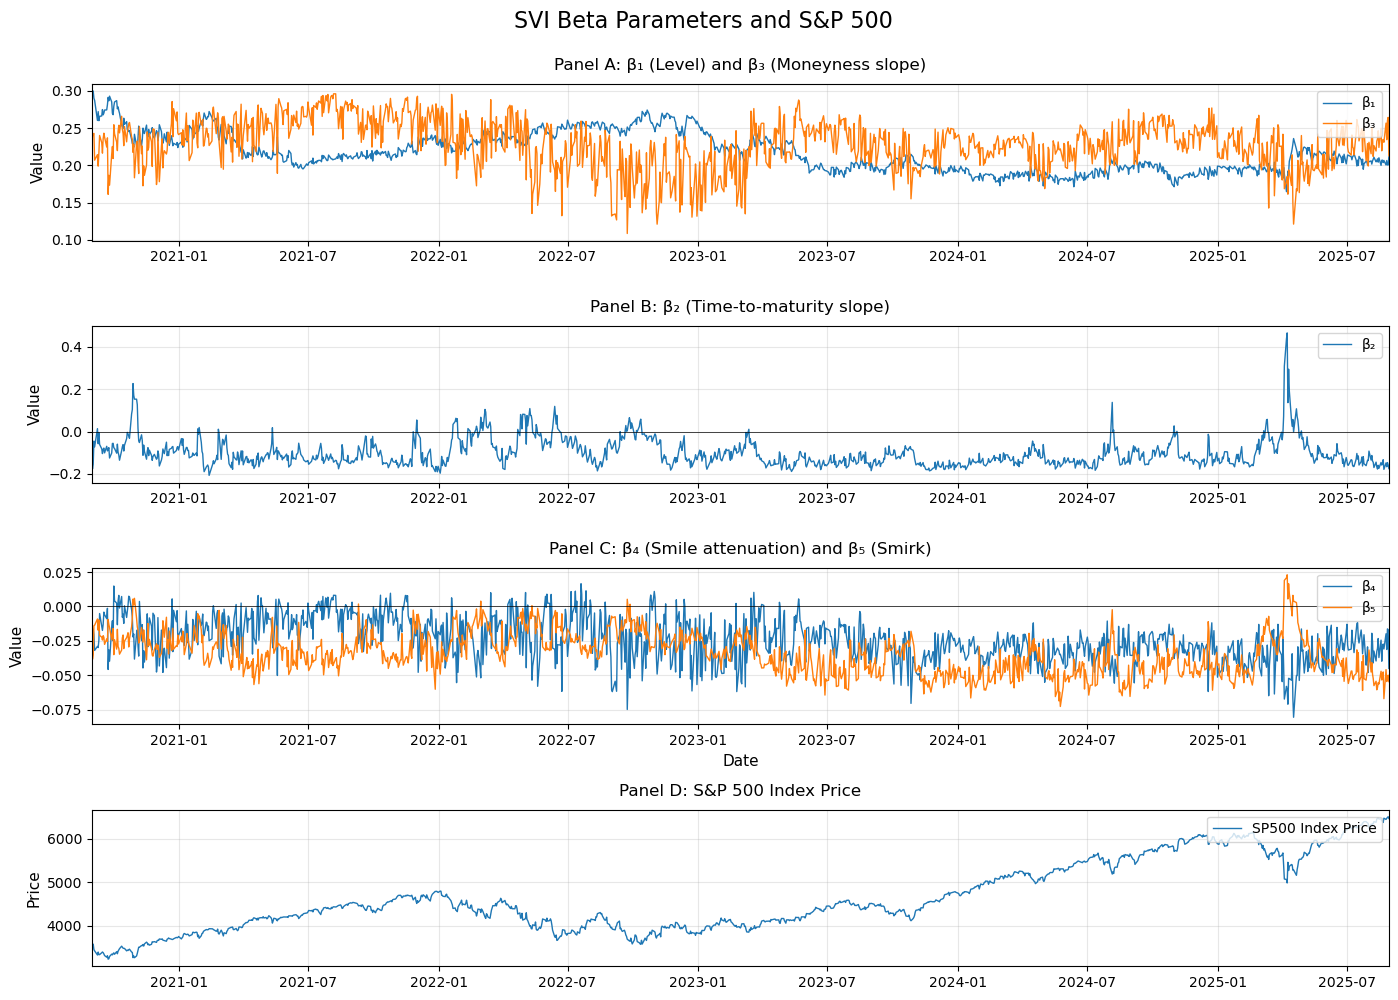

In [54]:
# Plot Beta Estimation
import matplotlib.pyplot as plt

# Create figure with 3 panels
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
fig.suptitle('SVI Beta Parameters and S&P 500', fontsize=16, y=0.995)

# Panel A: β₁ (Level) and β₃ (Moneyness slope)
ax1 = axes[0]
ax1.plot(beta['date'], beta['beta1'], linewidth=1, label='β₁', color='#1f77b4')
ax1.plot(beta['date'], beta['beta3'], linewidth=1, label='β₃', color='#ff7f0e')
ax1.set_ylabel('Value', fontsize=11)
ax1.set_title('Panel A: β₁ (Level) and β₃ (Moneyness slope)', fontsize=12, pad=10)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(beta['date'].min(), beta['date'].max())

# Panel B: β₂ (Time-to-maturity slope)
ax2 = axes[1]
ax2.plot(beta['date'], beta['beta2'], linewidth=1, label='β₂', color='#1f77b4')
ax2.set_ylabel('Value', fontsize=11)
ax2.set_title('Panel B: β₂ (Time-to-maturity slope)', fontsize=12, pad=10)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlim(beta['date'].min(), beta['date'].max())

# Panel C: β₄ (Smile attenuation) and β₅ (Smirk)
ax3 = axes[2]
ax3.plot(beta['date'], beta['beta4'], linewidth=1, label='β₄', color='#1f77b4')
ax3.plot(beta['date'], beta['beta5'], linewidth=1, label='β₅', color='#ff7f0e')
ax3.set_ylabel('Value', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_title('Panel C: β₄ (Smile attenuation) and β₅ (Smirk)', fontsize=12, pad=10)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlim(beta['date'].min(), beta['date'].max())

# Panel D
ax4 = axes[3]
ax4.plot(underlying_df['date'], underlying_df['price'], linewidth=1, label='SP500 Index Price', color='#1f77b4')
ax4.set_ylabel('Price', fontsize=11)
ax4.set_title('Panel D: S&P 500 Index Price', fontsize=12, pad=10)
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(underlying_df['date'].min(), underlying_df['date'].max())

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
